Based on these posts: 
* https://medium.com/@chrisfotache/text-classification-in-python-pipelines-nlp-nltk-tf-idf-xgboost-and-more-b83451a327e0
* https://github.com/keisukeirie/Amazon_review_helpfulness_prediction
* https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/
* https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22

In [56]:
!pip install -q boto3
!pip install -q xgboost==0.90
!pip install -q scikit-learn==0.20.3
!pip install -q nltk==3.3

tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [10]:
!head ./amazon20000.csv

In [11]:
df = pd.read_csv('amazon20000.csv')
df.shape

(19742, 15)

In [12]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


# Drop any NaNs

In [13]:
df.shape

(19742, 15)

In [14]:
df.isna().values.any()

True

In [15]:
df_cleaned_and_filtered = df.dropna()
df_cleaned_and_filtered = df_cleaned_and_filtered.reset_index()
df_cleaned_and_filtered.shape

(19741, 16)

In [16]:
df_cleaned_and_filtered = df_cleaned_and_filtered.query('helpful_votes > 0')
df_cleaned_and_filtered.shape

(2019, 16)

In [17]:
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31


In [18]:
df_cleaned_and_filtered['pct_helpful_votes'] = df_cleaned_and_filtered['helpful_votes'] / df_cleaned_and_filtered['total_votes']
df_cleaned_and_filtered.shape

(2019, 17)

In [19]:
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,pct_helpful_votes
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,0.944444
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31,0.833333
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31,1.000000
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31,1.000000
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31,1.000000


In [20]:
df_cleaned_and_filtered['is_helpful'] = df_cleaned_and_filtered['pct_helpful_votes'] > 0.75
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,pct_helpful_votes,is_helpful
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,0.944444,True
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31,0.833333,True
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31,1.000000,True
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31,1.000000,True
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31,1.000000,True


In [21]:
df_cleaned_and_filtered['is_positive_sentiment'] = (df_cleaned_and_filtered['star_rating'] >= 4).astype(int)
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,pct_helpful_votes,is_helpful,is_positive_sentiment
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,0.944444,True,1
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31,0.833333,True,1
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31,1.000000,True,1
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31,1.000000,True,1
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31,1.000000,True,0


In [22]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_cleaned_and_filtered)


## Balance the dataset

In [23]:
from sklearn.utils import resample

is_negative_sentiment_df = df_cleaned_and_filtered.query('is_positive_sentiment == 0')
is_positive_sentiment_df = df_cleaned_and_filtered.query('is_positive_sentiment == 1')

is_positive_downsampled_df = resample(is_positive_sentiment_df,
                                      replace = False, # sample without replacement
                                      n_samples = len(is_negative_sentiment_df), # match minority n
                                      random_state = 27) # reproducible results

df_cleaned_and_filtered = pd.concat([is_negative_sentiment_df, is_positive_downsampled_df])


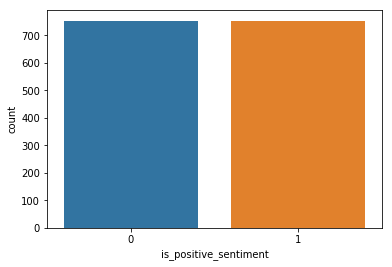

In [24]:
sns.countplot(x='is_positive_sentiment', data=df_cleaned_and_filtered)


Create X (features) and y (labels)

In [25]:
X = df_cleaned_and_filtered[['review_body']]
y = df_cleaned_and_filtered['is_positive_sentiment']

print('X.shape:  {}'.format(X.shape))
print('y.shape:  {}'.format(y.shape))

X.shape:  (1506, 1)
y.shape:  (1506,)


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

In [27]:
X_train.head(5)

,review_body
7456,"Honestly, if it weren't for the lady in the la..."
15406,I LOVE Hannibal!<br /><br />It's bar none one ...
2786,"A little slow, but I do get why."
7671,I have been an on and off fan of Survivor for ...
9940,You really can't tell who would stay and who w...


In [28]:
y_train.head(5)

7456     1
15406    1
2786     1
7671     1
9940     1
Name: is_positive_sentiment, dtype: int64

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

In [30]:
import nltk
import re
def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

### Create Scikit-Learn Pipeline with SGDClassifier

In [31]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('body', Pipeline([
            ('body_text_selector', TextSelector('review_body')),
            ('tfidf_vectorizer', TfidfVectorizer(tokenizer=Tokenizer, stop_words="english",
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
    ])),
    ('classifier', SGDClassifier(learning_rate='optimal'))
])

Fit the model

In [24]:
pipeline.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('body', Pipeline(memory=None,
     steps=[('body_text_selector', TextSelector(field='review_body')), ('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

Predict and calculate metrics

In [46]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

preds = pipeline.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, preds))
print('Precision: ', precision_score(y_test, preds, average=None))

Accuracy:  0.8278145695364238
Precision:  [0.7875     0.87323944]


In [47]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        72
           1       0.87      0.78      0.83        79

   micro avg       0.83      0.83      0.83       151
   macro avg       0.83      0.83      0.83       151
weighted avg       0.83      0.83      0.83       151



In [48]:
df_cm = confusion_matrix(y_test, preds)
df_cm

array([[63,  9],
       [17, 62]])

In [49]:
# TODO:  Explain the classifier

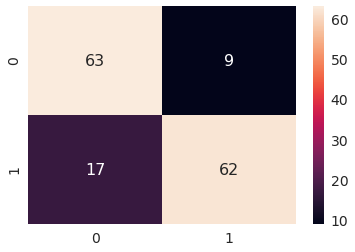

In [50]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

# TODO:  Balance the dataset before training
# TODO:  Add labels to each quadrant (predicted y-axis, actual x-axis)

plt.show()

### Create Scikit-Learn Pipeline with XGBoostClassifier

In [51]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('body', Pipeline([
            ('body_text_selector', TextSelector('review_body')),
            ('tfidf_vectorizer', TfidfVectorizer(tokenizer=Tokenizer, stop_words="english",
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
    ])),
    ('classifier', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1)),
])

Fit the model

In [52]:
pipeline.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('body', Pipeline(memory=None,
     steps=[('body_text_selector', TextSelector(field='review_body')), ('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'...ale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None))])

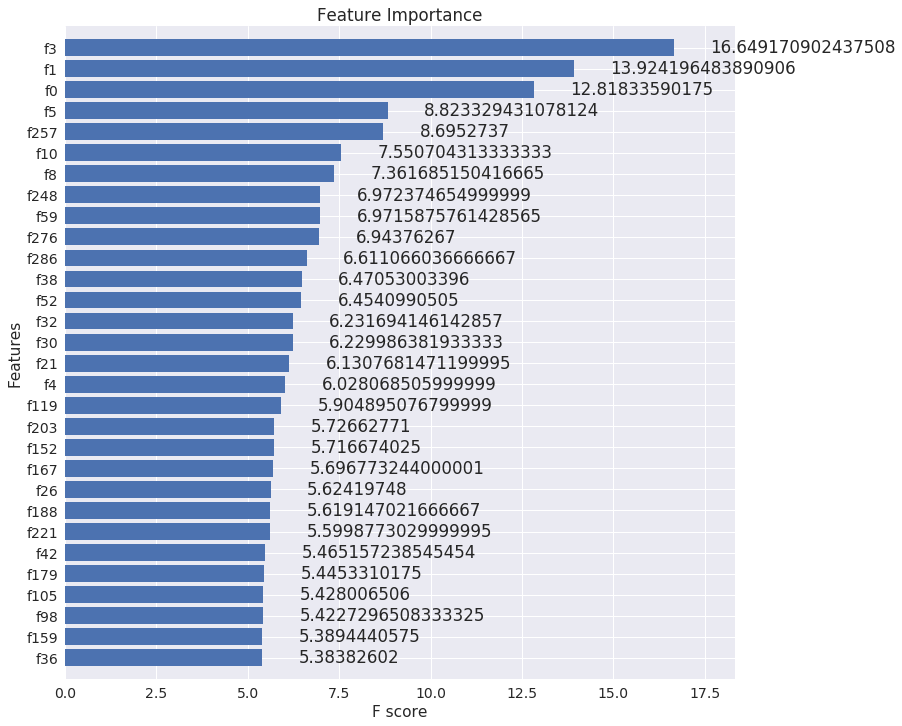

In [54]:
##
# TODO:  https://towardsdatascience.com/xgboost-in-amazon-sagemaker-28e5e354dbcd
#        https://gitlab.com/juliensimon/awsdevdays2020/-/blob/master/mls1/XGBoost.ipynb
##

#plot feature importance

import matplotlib.pyplot as plt
import xgboost

fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(classifier.steps[1][1], importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = True)
plt.title('Feature Importance')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

preds = pipeline.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, preds))
print('Precision: ', precision_score(y_test, preds, average=None))

In [ ]:
print(classification_report(y_test, preds))

In [ ]:
df_cm = confusion_matrix(y_test, preds)
df_cm

In [ ]:
# TODO:  Explain the classifier

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

# TODO:  Add labels to each quadrant (False, True / False, True)

plt.show()